# Berlin's public transportation system - Network Science Project

# Introduction

The project aims to represent and analyse the public transport network in Berlin, the capital of Germany. For this study, network science techniques and geographical visualisation tools will be employed in order to obtain an in-depth understanding of the transport network. Using the data provided, which include information on connections between stops, geographical coordinates (latitude and longitude) and the characteristics of the different types of transport, the aim is to construct a detailed model of the network.

The main intention is to explore the structural and functional characteristics of the network, identifying key elements such as:

- Central nodes: stops with high connectivity or of strategic importance.
- Relevant links: routes with high frequency or special characteristics.
- Transport types: trams, metro, buses and other means of transport that make up the network.


### Table of contents 
1. Data Collection: 
- Data Modelling
- Description of the final dataset 
 
2. Exploratory Data Analysis:
- Map Visualizations
- Distribution of transport types
- Analysis of the attributes

3. Network Construction:
- Graph creation

4. Network Visualization
- Visualisation of the different types of transport
- Overall network structure

5. Network Analysis
- Degree Analysis (minimum, maximum, average and degree distribution)
- Comparison with a random graph (Erdős-Rényi model)
- Centrality Measures

6. Community Detection
- Louvain method

7. Link Prediction

# 1. Data Collection
As already mentioned, the aim of this analysis is to study the public transport network in the city of Berlin.

The dataset used comes from the open access archive dedicated to the publication of scientific data and research, and was obtained from the following link: https://data.niaid.nih.gov/resources?id=zenodo_1133857.

- Bibliographic reference:
Kujala, R., Weckström, C., Darst, R. et al. A collection of public transport network data sets for 25 cities. Sci Data 5, 180089 (2018). https://doi.org/10.1038/sdata.2018.89

This dataset contains public transport information for 25 cities worldwide, derived from General Transit Feed Specification (GTFS) files. GTFS files are a collection of related CSV tables describing operations, timetables and structures of public transport systems. Thanks to this standardisation, it is possible to study the organisation of networks and better understand the urban structure of each city.

The cities included in this version of the dataset are: Adelaide, Belfast, Berlin, Bordeaux, Brisbane, Canberra, Detroit, Dublin, Grenoble, Helsinki, Kuopio, Lisbon, Luxembourg, Melbourne, Nantes, Palermo, Paris, Prague, Rennes, Rome, Sydney, Toulouse, Turku, Venice and Winnipeg.

For this analysis, I have chosen to focus on the city of Berlin. This choice is motivated by the importance of this city as an economic and cultural centre. The data are about 2016.

### Data Modelling

In [174]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
from statsmodels.distributions.empirical_distribution import ECDF
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import random
import ast

The dataset used, named ‘network_combined’, is so called because it combines all public transport modes in the city of Berlin. In this analysis, the main public transport lines will be examined, including trams, underground, trains, buses and ferries. These modes represent all available public transport options in the city of Berlin, offering a comprehensive and integrated view of the city's network.

In [175]:
network_combined = pd.read_csv('berlin/network_combined.csv', delimiter= ';')
network_combined['attr_dict'] = network_combined['attr_dict'].apply(ast.literal_eval)

network_combined['duration_avg'] = network_combined['attr_dict'].apply(lambda x: x['duration_avg'])
network_combined['n_vehicles'] = network_combined['attr_dict'].apply(lambda x: x['n_vehicles'])
network_combined['route_type'] = network_combined['attr_dict'].apply(lambda x: x['route_type'])
network_combined['route_I_counts'] = network_combined['attr_dict'].apply(lambda x: x['route_I_counts'])
network_combined['d'] = network_combined['attr_dict'].apply(lambda x: x['d'])

network_combined['from_stop_I'] = network_combined['from_stop_I'].astype(str)
network_combined['to_stop_I'] = network_combined['to_stop_I'].astype(str)

Next, a file in GeoJSON format was used containing all the information about the individual stops in the public transport network. This file includes details such as the stop ID, the name of the stop (which may correspond, for example, to a street for bus stops or the official name of a station), as well as the relevant geographical coordinates (latitude and longitude), which allow each stop to be precisely geolocalised.

In [176]:
stops = gpd.read_file('berlin/stops.geojson')
stops['from_lat'] = stops['geometry'].y
stops['from_long'] = stops['geometry'].x

stops['stop_I'] = stops['stop_I'].astype(str)

Next, a dataset will be created that relates the stops, including detailed departure and arrival information.

In [177]:
from_stops = network_combined[['from_stop_I', 'to_stop_I', 'duration_avg', 'n_vehicles', 'route_type', 'route_I_counts', 'd', 'attr_dict']].merge(
    stops[['stop_I', 'name', 'from_lat', 'from_long']], 
    left_on='from_stop_I', 
    right_on='stop_I', 
    how='left'
).rename(columns={
    'stop_I': 'from',
    'name': 'from_name'
})

In [178]:
from_stops.head()

from_stop_I to_stop_I  duration_avg  n_vehicles  route_type  \
0       10924     10920         120.0          17           3   
1       10924     10794          60.0           2           3   
2       10924     10435         132.5          72           3   
3       10924     10436          60.0          53           3   
4       10925     10492         120.0          13           3   

               route_I_counts     d  \
0                   {720: 17}   676   
1                    {592: 2}   713   
2  {720: 17, 581: 54, 597: 1}  1033   
3                   {581: 53}   696   
4           {549: 3, 550: 10}   374   

                                           attr_dict   from  \
0  {'duration_avg': 120.0, 'n_vehicles': 17, 'rou...  10924   
1  {'duration_avg': 60.0, 'n_vehicles': 2, 'route...  10924   
2  {'duration_avg': 132.5, 'n_vehicles': 72, 'rou...  10924   
3  {'duration_avg': 60.0, 'n_vehicles': 53, 'rout...  10924   
4  {'duration_avg': 120.0, 'n_vehicles': 13, 'rou...  10925   

                               from_name   from_lat  from_long  
0  Schwanebeck (BAR), Neue Kärntner Str.  52.628913  13.528529  
1  Schwanebeck (BAR), Neue Kärntner Str.  52.628913  13.528529  
2  Schwanebeck (BAR), Neue Kärntner Str.  52.628913  13.528529  
3  Schwanebeck (BAR), Neue Kärntner Str.  52.628913  13.528529  
4                   Bernau, Puschkinstr.  52.684066  13.591443

In [179]:
to_stops = network_combined[['from_stop_I', 'to_stop_I', 'duration_avg', 'n_vehicles', 'route_type', 'route_I_counts', 'd', 'attr_dict']].merge(
    stops[['stop_I', 'name', 'from_lat', 'from_long']], 
    left_on='to_stop_I', 
    right_on='stop_I', 
    how='left'
).rename(columns={
    'stop_I': 'to',
    'name': 'to_name',
    'from_lat': 'to_lat',
    'from_long': 'to_long'
})

In [180]:
to_stops.head()

from_stop_I to_stop_I  duration_avg  n_vehicles  route_type  \
0       10924     10920         120.0          17           3   
1       10924     10794          60.0           2           3   
2       10924     10435         132.5          72           3   
3       10924     10436          60.0          53           3   
4       10925     10492         120.0          13           3   

               route_I_counts     d  \
0                   {720: 17}   676   
1                    {592: 2}   713   
2  {720: 17, 581: 54, 597: 1}  1033   
3                   {581: 53}   696   
4           {549: 3, 550: 10}   374   

                                           attr_dict     to  \
0  {'duration_avg': 120.0, 'n_vehicles': 17, 'rou...  10920   
1  {'duration_avg': 60.0, 'n_vehicles': 2, 'route...  10794   
2  {'duration_avg': 132.5, 'n_vehicles': 72, 'rou...  10435   
3  {'duration_avg': 60.0, 'n_vehicles': 53, 'rout...  10436   
4  {'duration_avg': 120.0, 'n_vehicles': 13, 'rou...  10492   

                                to_name     to_lat    to_long  
0         Schwanebeck (BAR), Kleiststr.  52.629607  13.518583  
1       Schwanebeck (BAR), Bodenseestr.  52.632628  13.519929  
2               Schwanebeck (BAR), Dorf  52.625556  13.542797  
3  Schwanebeck (BAR), Lindenberger Str.  52.631434  13.519090  
4               Bernau, Sachtelebenstr.  52.685330  13.586298

In [181]:
network_df = pd.merge(from_stops, to_stops[['to', 'to_name', 'to_lat', 'to_long', 'to_stop_I']], on='to_stop_I')

In [182]:
network_df['from_geometry'] = network_df.apply(lambda row: Point(row['from_long'], row['from_lat']), axis=1)
network_df['to_geometry'] = network_df.apply(lambda row: Point(row['to_long'], row['to_lat']), axis=1)

In [183]:
network_df = network_df[['from', 'from_name', 'from_long', 'from_lat', 'from_geometry', 'to', 'to_name', 'to_long', 'to_lat', 'to_geometry', 'route_type', 'n_vehicles', 'duration_avg', 'd']]

The designation “Berlin Hbf (tief)” denotes the underground tracks of Berlin Central Station, located about 15 meters below street level and used mainly for long-distance trains on the north-south route. To ensure consistency in the data and facilitate analysis of the transportation network, it is appropriate to standardize this designation to “S+U Berlin Hauptbahnhof,” treating the entire facility as a single entity.


In [184]:
network_df = network_df.replace("S+U Berlin Hauptbahnhof (tief)", "S+U Berlin Hauptbahnhof", regex=False)

In [185]:
network_df = network_df.drop_duplicates()

In [186]:
network_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12094 entries, 0 to 42963
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   from           12094 non-null  object 
 1   from_name      12094 non-null  object 
 2   from_long      12094 non-null  float64
 3   from_lat       12094 non-null  float64
 4   from_geometry  12094 non-null  object 
 5   to             12094 non-null  object 
 6   to_name        12094 non-null  object 
 7   to_long        12094 non-null  float64
 8   to_lat         12094 non-null  float64
 9   to_geometry    12094 non-null  object 
 10  route_type     12094 non-null  int64  
 11  n_vehicles     12094 non-null  int64  
 12  duration_avg   12094 non-null  float64
 13  d              12094 non-null  int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 1.4+ MB


### Description of the final dataset 

In [187]:
network_df.to_csv('berlin/network_df.csv', index=False)

In [188]:
network_df.head()

from                              from_name  from_long   from_lat  \
0  10924  Schwanebeck (BAR), Neue Kärntner Str.  13.528529  52.628913   
1  10924  Schwanebeck (BAR), Neue Kärntner Str.  13.528529  52.628913   
3  10924  Schwanebeck (BAR), Neue Kärntner Str.  13.528529  52.628913   
7  10924  Schwanebeck (BAR), Neue Kärntner Str.  13.528529  52.628913   
9  10925                   Bernau, Puschkinstr.  13.591443  52.684066   

                 from_geometry     to                               to_name  \
0  POINT (13.528529 52.628913)  10920         Schwanebeck (BAR), Kleiststr.   
1  POINT (13.528529 52.628913)  10794       Schwanebeck (BAR), Bodenseestr.   
3  POINT (13.528529 52.628913)  10435               Schwanebeck (BAR), Dorf   
7  POINT (13.528529 52.628913)  10436  Schwanebeck (BAR), Lindenberger Str.   
9  POINT (13.591443 52.684066)  10492               Bernau, Sachtelebenstr.   

     to_long     to_lat                  to_geometry  route_type  n_vehicles  \
0  13.518583  52.629607  POINT (13.518583 52.629607)           3          17   
1  13.519929  52.632628  POINT (13.519929 52.632628)           3           2   
3  13.542797  52.625556  POINT (13.542797 52.625556)           3          72   
7  13.519090  52.631434   POINT (13.51909 52.631434)           3          53   
9  13.586298  52.685330   POINT (13.586298 52.68533)           3          13   

   duration_avg     d  
0         120.0   676  
1          60.0   713  
3         132.5  1033  
7          60.0   696  
9         120.0   374

The final dataset that was obtained consists of 12094 rows, each representing a connection between one station and another. The dataset indicates the stations/stops, the geographical location, the type of line, and the values that will be used as edge weights. In particular, 
- from / to : ID of the departure and arrival station;
- from_name / to_name : Name of the arrival and departure station or stop;
- route_type : Identifier for a route;
- n_vehicles : Number of public transport vehicles that have travelled between two stops within a time interval;
- duration_avg : Average travel time between stops (in seconds).
- d : Distance between stops (in metres).

In addition, as stated above, information on geographical location is also present.

## 2. Exploratory Data Analysis (EDA)

### Map visualization

In [189]:
city_map = gpd.read_file('berlin/berlin_map.geojson')
gdf = gpd.GeoDataFrame(network_df, geometry=gpd.GeoSeries.from_xy(network_df['from_long'], network_df['from_lat']))

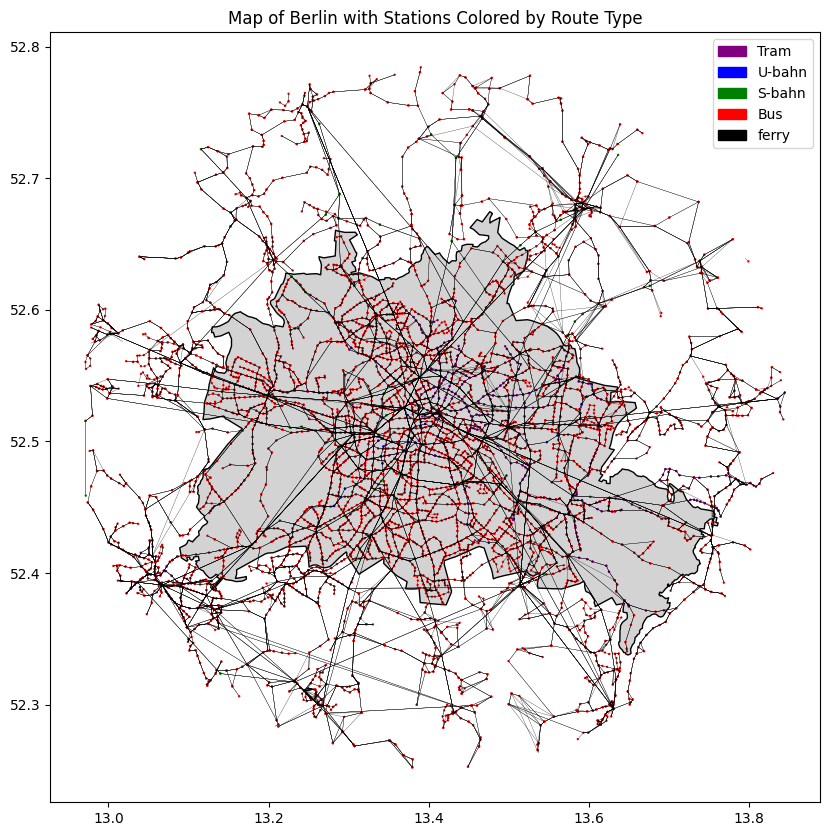

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))
city_map.plot(ax=ax, color='lightgrey', edgecolor='black')

route_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'red', 4: 'black'}

gdf['color'] = gdf['route_type'].map(route_colors)  

gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=0.5, label='Stations')

legend_labels = [mpatches.Patch(color='purple', label='Tram'),
                 mpatches.Patch(color='blue', label='U-bahn'),
                 mpatches.Patch(color='green', label='S-bahn'),
                 mpatches.Patch(color='red', label='Bus'),
                 mpatches.Patch(color='black', label='ferry')]

ax.legend(handles=legend_labels)

plt.title('Map of Berlin with Stations Colored by Route Type')

routes = gpd.read_file('berlin/routes.geojson') 
sections = gpd.read_file('berlin/sections.geojson') 
routes.plot(ax=ax, color= 'black', linewidth=0.2, label='Routes')
sections.plot(ax=ax, color= 'black', linewidth=0.2, label='Sections')

plt.show()

Since the dataset also included stations located outside the Berlin city boundaries, in particular in the neighbouring city of Potsdam, it was observed that these significantly influenced the results of the analysis. The presence of outside stations could in fact distort the understanding of the Berlin-specific transport network by introducing connections and flows that are not properly part of the city itself.

To ensure that the analysis focuses exclusively on Berlin's urban transport network and that the results accurately reflect the city's internal dynamics, it was decided to exclude all stations located outside Berlin's geographical boundaries. This approach eliminates noise caused by external influences and provides a clearer and more consistent representation of Berlin's public transport network.

In [191]:
stations_gdf = gdf.set_crs(city_map.crs)

In [192]:
stations_in_berlin = stations_gdf[stations_gdf.within(city_map.unary_union)]

print(f"Number of initial stations: {len(stations_gdf)}")
print(f"Number of stations inside Berlin: {len(stations_in_berlin)}")

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_16963/143838529.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_berlin = stations_gdf[stations_gdf.within(city_map.unary_union)]


Number of initial stations: 12094
Number of stations inside Berlin: 7832


In [193]:
stations_in_berlin_ids = stations_in_berlin['from'].unique()

network_df = network_df[
    (network_df['from'].isin(stations_in_berlin_ids)) &
    (network_df['to'].isin(stations_in_berlin_ids))
]

### Distribution of Transport Types

In the initial phase of the dataset analysis, the objective is to examine the distribution of the type of means of transport for each type of route. This gives a preliminary overview of the frequency and relative importance of the different means of transport within the urban network, providing a basis for further investigation.

For a more detailed description, the transportation types are:
- Tram : Any light rail or street level system within a metropolitan area;
- U-bahn : Subway, Metro. Any underground rail system within a metropolitan area;
- S-bahn : Rail. Used for intercity or long-distance travel;
- Bus : Used for short- and long-distance bus routes.
- Ferry : Used for short- and long-distance boat service.

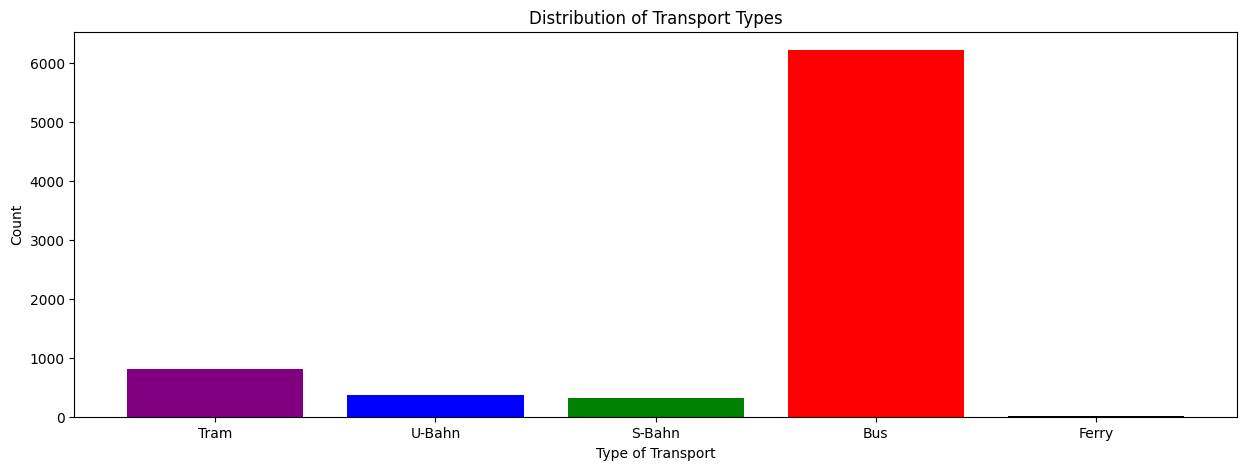

In [194]:
transport_labels = ['Tram', 'U-Bahn', 'S-Bahn', 'Bus', 'Ferry']
route_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'red', 4: 'black'}

route_counts = network_df['route_type'].value_counts().sort_index()

plt.figure(figsize=(15, 5))
plt.bar(route_counts.index, route_counts.values, color=[route_colors[i] for i in route_counts.index])
plt.title("Distribution of Transport Types")
plt.xlabel("Type of Transport")
plt.ylabel("Count")
plt.xticks(ticks=range(len(transport_labels)), labels=transport_labels)

plt.show()

There is a significant difference between the number of buses and other means of transport. Buses, in fact, play a key role in reaching the more peripheral and remote areas of the city, where trams, metros and S-Bahns do not arrive. While the latter focus on main routes and high-density areas, buses provide a wider coverage, connecting even the most distant neighbourhoods and offering a capillary transport network that complements that of other public transport modes.

### Analysis of the attributes

/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_16963/40893090.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route_type', y=column, data=network_df, palette=route_colors)
/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_16963/40893090.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route_type', y=column, data=network_df, palette=route_colors)
/var/folders/85/5nsqwlmd1xx9qfh9rn8rll2c0000gn/T/ipykernel_16963/40893090.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='route_type', y=column, data=netwo

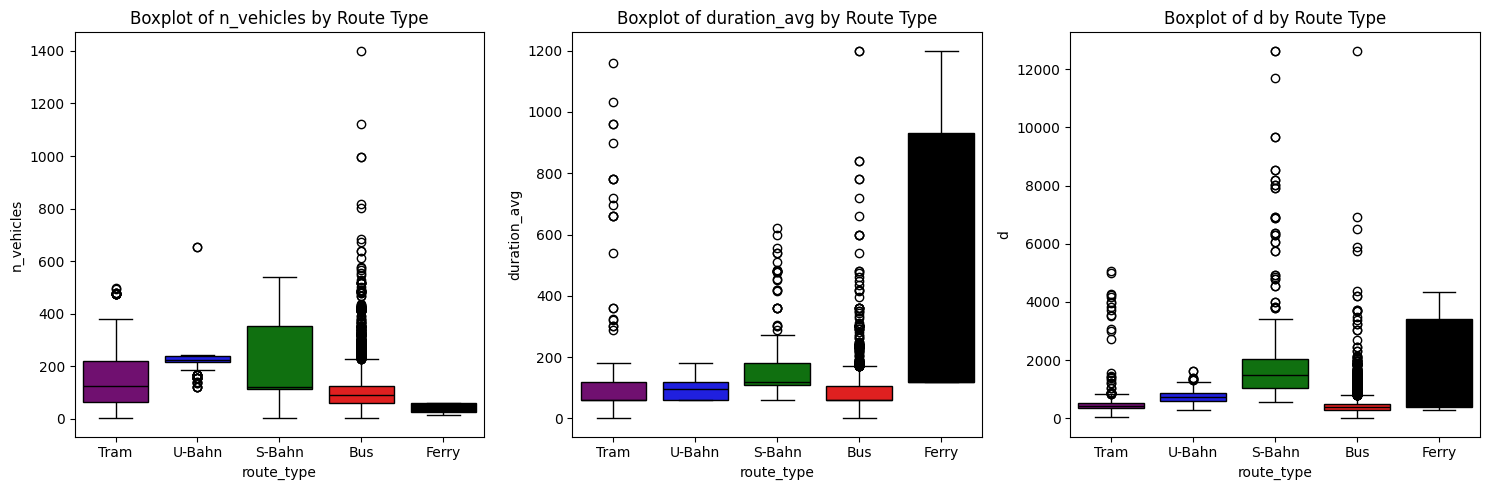

In [195]:
# Boxplot

transport_labels = ['Tram', 'U-Bahn', 'S-Bahn', 'Bus', 'Ferry']
route_colors = {'0': 'purple', '1': 'blue', '2': 'green', '3': 'red', '4': 'black'}

columns_to_plot = ['n_vehicles', 'duration_avg', 'd']

plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='route_type', y=column, data=network_df, palette=route_colors)
    plt.title(f'Boxplot of {column} by Route Type')
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=transport_labels)

plt.tight_layout()
plt.show()

The boxplots above show that the S-Bahn travels, on average, the longest distance and has the longest travel time compared to other modes of transportation. This can be attributed to the fact that the S-Bahn often connects more suburban areas with the city center, traveling longer distances and facing more stops along the way. 

It is important to note that the ferry has a significantly higher duration, mainly due to its technical characteristics, such as the time required to cross bodies of water and specific landings. Since the ferry has unique characteristics compared to other modes of transportation, it should be considered separately in the analysis. In addition, there are only 6 routes in the dataset involving the ferry. 

Regarding the number of vehicles, the metro shows the highest values. This is easily explained by its high frequency and high demand for transportation in densely populated urban areas, where the subway is often the preferred option for public transportation. Indeed, the subway operates in high-density areas and during peak hours, with a large flow of passengers, thus resulting in the highest number of vehicles on the road compared to other types of transportation.

In [196]:
network_df[network_df['route_type'] == 4]

from                       from_name  from_long   from_lat  \
8844    949          S Wannsee Bhf (Berlin)  13.179104  52.421461   
26732  2744        Müggelbergallee (Berlin)  13.589001  52.418457   
27332  2805          Wilhelmstrand (Berlin)  13.496825  52.474107   
28044  2882       Wassersportallee (Berlin)  13.579928  52.416305   
28381  2928  Baumschulenstr./Fähre (Berlin)  13.494793  52.471886   
31576   691             Alt-Kladow (Berlin)  13.144279  52.454319   

                     from_geometry    to                         to_name  \
8844   POINT (13.179104 52.421461)   691             Alt-Kladow (Berlin)   
26732  POINT (13.589001 52.418457)  2882       Wassersportallee (Berlin)   
27332  POINT (13.496825 52.474107)  2928  Baumschulenstr./Fähre (Berlin)   
28044  POINT (13.579928 52.416305)  2744        Müggelbergallee (Berlin)   
28381  POINT (13.494793 52.471886)  2805          Wilhelmstrand (Berlin)   
31576  POINT (13.144279 52.454319)   949          S Wannsee Bhf (Berlin)   

         to_long     to_lat                  to_geometry  route_type  \
8844   13.144279  52.454319  POINT (13.144279 52.454319)           4   
26732  13.579928  52.416305  POINT (13.579928 52.416305)           4   
27332  13.494793  52.471886  POINT (13.494793 52.471886)           4   
28044  13.589001  52.418457  POINT (13.589001 52.418457)           4   
28381  13.496825  52.474107  POINT (13.496825 52.474107)           4   
31576  13.179104  52.421461  POINT (13.179104 52.421461)           4   

       n_vehicles  duration_avg     d  
8844           14        1200.0  4354  
26732          61         120.0   660  
27332          55         120.0   283  
28044          61         120.0   660  
28381          55         120.0   283  
31576          14        1200.0  4354

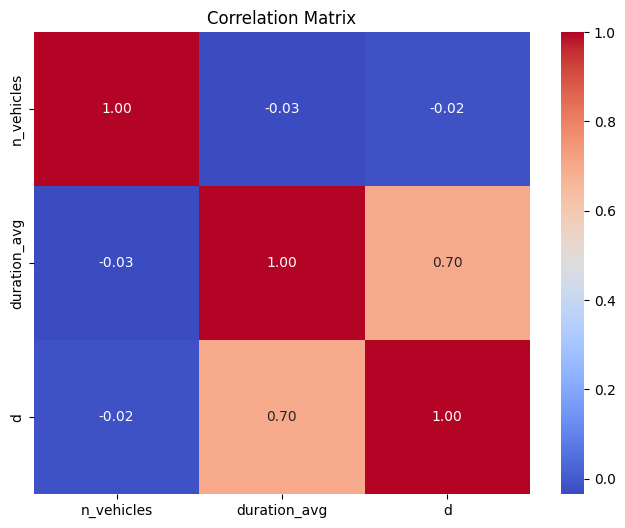

In [197]:
# Correlation Matrix

correlation_matrix = network_df[['n_vehicles', 'duration_avg', 'd']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()


The correlation matrix shows that, logically, trips with longer distance are closely correlated with longer trip duration. However, no significant correlation emerges between distance traveled or trip duration and the number of vehicles passing between two stations in a given time interval.

## 3. Network Construction
The objective of this analysis is to study the public transport network of Germany's capital city, Berlin. In particular, the focus is on observing the connections between the different stations and identifying those that play a more central or important role within the network.

In this case, the graph will be composed by: 
- Nodes : Each node represents a single public transport station or stop;
- Edges : The arcs describe the connections between stations, which correspond to the routes of different public transport;
- Weights :The weights associated with the arcs reflect the frequency of connections between stations, e.g. the number of vehicles travelling a specific route;
- Graph type : The network will be represented as a directed and weighted graph.

The graph is directed, which means that each connection is oriented. A connection in one direction is treated separately from one in the opposite direction. 

### Graph Creation

During the creation of the graph, each connection between two nodes is represented as a direct arc, indicating the direction of flow in the network. Attributes such as geographic location (latitude and longitude) can be added to each node. Finally, the graph is weighted using connection frequency, expressed by the number of vehicles passing between nodes, average duration and distance to represent the relative importance of each link.

In [198]:
G = nx.DiGraph()

for _, row in network_df.iterrows():
    G.add_node(row['from_name'], lat=row['from_lat'], lon=row['from_long'])
    G.add_node(row['to_name'], lat=row['to_lat'], lon=row['to_long'])
    

for _, row in network_df.iterrows():
    G.add_edge(
        row['from_name'], row['to_name'],
        n_vehicles=row['n_vehicles'],
        duration_avg=row['duration_avg'],
        d=row['d'],
        route_type=row['route_type'] 
    )

It is essential to remove loops, that is, edges connecting a node to itself, as these make no logical sense in the context of public transport. Such links do not represent real movements between stations and, consequently, could introduce distortions into the network analysis.

In [199]:
G.remove_edges_from(nx.selfloop_edges(G))

In [200]:
order = G.order()
size = G.size()

print(f'The graph contains {order} stations (nodes) and {size} direct connections (edges).')

The graph contains 2893 stations (nodes) and 7254 direct connections (edges).


The graph representing the transportation network consists of 2893 nodes representing a station or a stop and 7254 edges, i.e. connections between two stations, taking into account the direction.

## 4. Network Visualization

### Visualisation of the different types of transport

The next step is to visualise the connections between the different stations of the public transport system. The main objective of this phase is to graphically represent the links between stops, subdividing them according to the type of transport mode used. First, graphs are presented showing the connections between stops, organised according to the different modes of transport, such as tram, underground (U-Bahn), railway (S-Bahn) and bus. These graphs make it possible to clearly visualise how each type of mode connects stations, facilitating the analysis of traffic flows and the relative importance of each mode within the network.

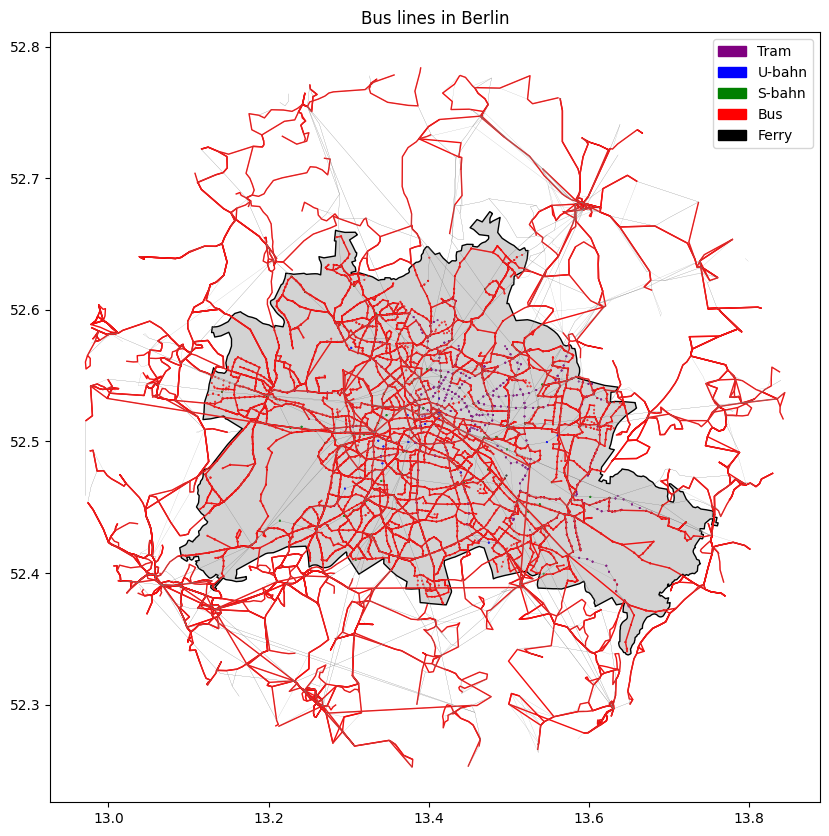

In [203]:
# Bus
fig, ax = plt.subplots(figsize=(10, 10))
city_map = gpd.read_file('berlin/berlin_map.geojson')
city_map.plot(ax=ax, color='lightgrey', edgecolor='black')

gdf = gpd.GeoDataFrame(network_df, geometry=gpd.GeoSeries.from_xy(network_df['from_long'], network_df['from_lat']))
route_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'red', 4: 'black'}
gdf['color'] = gdf['route_type'].map(route_colors)

routes = gpd.read_file('berlin/routes.geojson')
routes_filtered = routes[routes['route_type'] == 3]

gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=0.2, label='Stations')

legend_labels = [mpatches.Patch(color='purple', label='Tram'),
                 mpatches.Patch(color='blue', label='U-bahn'),
                 mpatches.Patch(color='green', label='S-bahn'),
                 mpatches.Patch(color='red', label='Bus'),
                 mpatches.Patch(color='black', label='Ferry')]

ax.legend(handles=legend_labels)

plt.title('Bus lines in Berlin')

routes_filtered.plot(ax=ax, color='red', linewidth=1, label='Routes (Bus)')

sections = gpd.read_file('berlin/sections.geojson')
sections.plot(ax=ax, color='grey', linewidth=0.1, label='Sections')

plt.show()

As can be seen, the bus is the means of transport that offers the most extensive network of connections within the city, thanks to its ramified structure. Its ability to reach a wide range of stops, even in outlying areas, allows it to cover practically every area of the city, offering an extremely widespread and well-distributed public transport network.

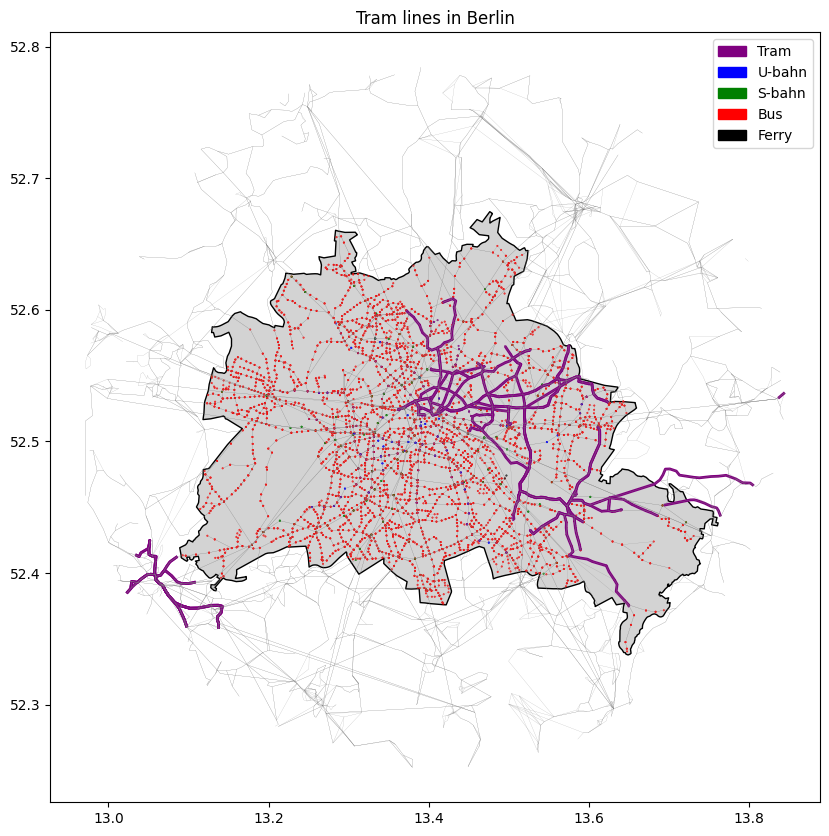

In [204]:
# Tram
fig, ax = plt.subplots(figsize=(10, 10))
city_map = gpd.read_file('berlin/berlin_map.geojson')
city_map.plot(ax=ax, color='lightgrey', edgecolor='black')

gdf = gpd.GeoDataFrame(network_df, geometry=gpd.GeoSeries.from_xy(network_df['from_long'], network_df['from_lat']))

gdf['color'] = gdf['route_type'].map(route_colors)

routes = gpd.read_file('berlin/routes.geojson')
routes_filtered = routes[routes['route_type'] == 0]

gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=0.2, label='Stations')

legend_labels = [mpatches.Patch(color='purple', label='Tram'),
                 mpatches.Patch(color='blue', label='U-bahn'),
                 mpatches.Patch(color='green', label='S-bahn'),
                 mpatches.Patch(color='red', label='Bus'),
                 mpatches.Patch(color='black', label='Ferry')]

ax.legend(handles=legend_labels)

plt.title('Tram lines in Berlin')

routes_filtered.plot(ax=ax, color='purple', linewidth=2, label='Routes (Tram)')

sections = gpd.read_file('berlin/sections.geojson')
sections.plot(ax=ax, color='grey', linewidth=0.1, label='Sections')

plt.show()

As can be seen, Berlin's tram network extends almost solely over the territories of the former East Berlin. 

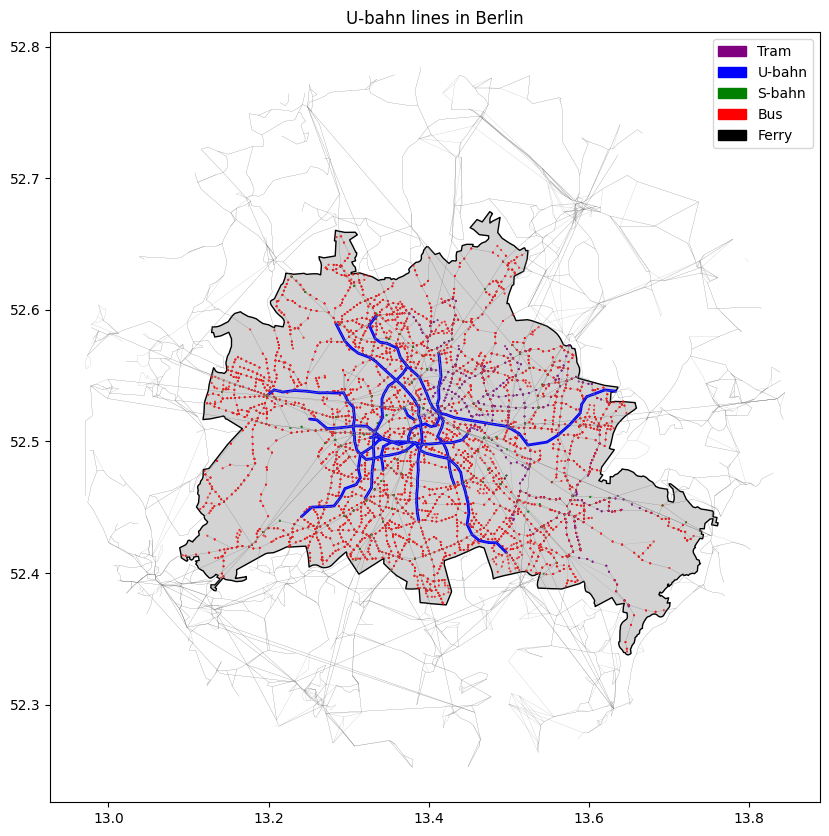

In [205]:
# U-bahn
fig, ax = plt.subplots(figsize=(10, 10))
city_map = gpd.read_file('berlin/berlin_map.geojson')
city_map.plot(ax=ax, color='lightgrey', edgecolor='black')

gdf = gpd.GeoDataFrame(network_df, geometry=gpd.GeoSeries.from_xy(network_df['from_long'], network_df['from_lat']))

gdf['color'] = gdf['route_type'].map(route_colors)

routes = gpd.read_file('berlin/routes.geojson')
routes_filtered = routes[routes['route_type'] == 1]

gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=0.2, label='Stations')

legend_labels = [mpatches.Patch(color='purple', label='Tram'),
                 mpatches.Patch(color='blue', label='U-bahn'),
                 mpatches.Patch(color='green', label='S-bahn'),
                 mpatches.Patch(color='red', label='Bus'),
                 mpatches.Patch(color='black', label='Ferry')]

ax.legend(handles=legend_labels)

plt.title('U-bahn lines in Berlin')

routes_filtered.plot(ax=ax, color='blue', linewidth=2, label='Routes (Tram)')

sections = gpd.read_file('berlin/sections.geojson')
sections.plot(ax=ax, color='grey', linewidth=0.1, label='Sections')

plt.show()

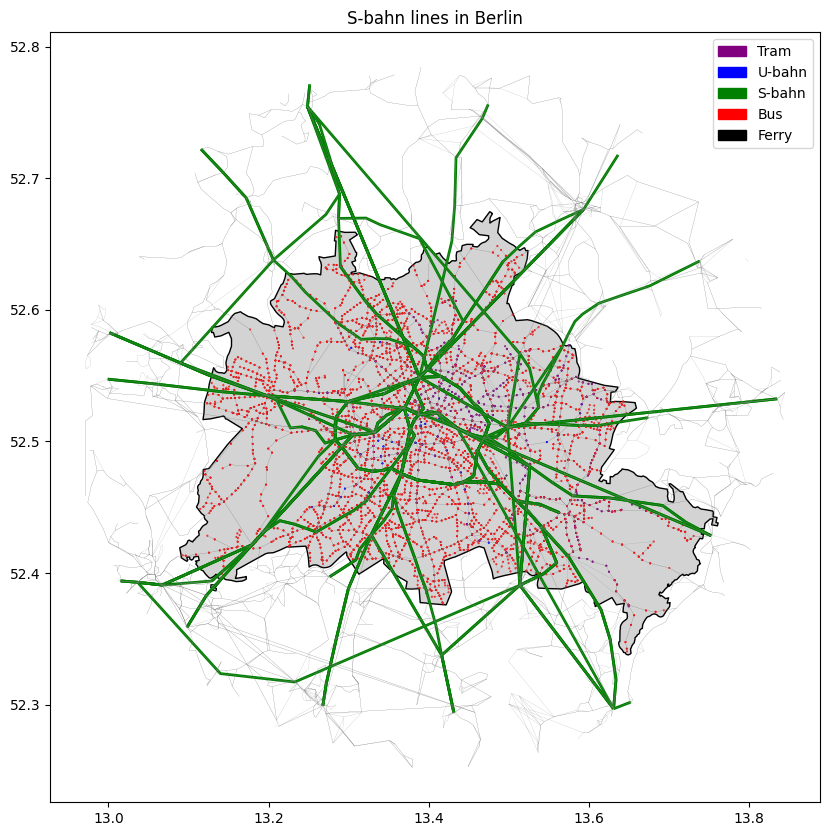

In [206]:
# S-bahn
fig, ax = plt.subplots(figsize=(10, 10))
city_map = gpd.read_file('berlin/berlin_map.geojson')
city_map.plot(ax=ax, color='lightgrey', edgecolor='black')

gdf = gpd.GeoDataFrame(network_df, geometry=gpd.GeoSeries.from_xy(network_df['from_long'], network_df['from_lat']))

gdf['color'] = gdf['route_type'].map(route_colors)

routes = gpd.read_file('berlin/routes.geojson')
routes_filtered = routes[routes['route_type'] == 2]

gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=0.2, label='Stations')

legend_labels = [mpatches.Patch(color='purple', label='Tram'),
                 mpatches.Patch(color='blue', label='U-bahn'),
                 mpatches.Patch(color='green', label='S-bahn'),
                 mpatches.Patch(color='red', label='Bus'),
                 mpatches.Patch(color='black', label='Ferry')]

ax.legend(handles=legend_labels)

plt.title('S-bahn lines in Berlin')

routes_filtered.plot(ax=ax, color='green', linewidth=2, label='Routes (S-bahn)')

sections = gpd.read_file('berlin/sections.geojson')
sections.plot(ax=ax, color='grey', linewidth=0.1, label='Sections')

plt.show()

Other modes of transport, such as the underground and the railway, provide more direct and concentrated services in the main urban areas of the city. As can be seen, the tram is mainly concentrated in the western part of Berlin, efficiently covering this part of the city with a well-developed and direct network of connections.

### Overall network structure

Finally, the graph created with Gephi is presented, which allows us to visualise the network and observe some important statistics of the graph.

- *Node colour*: The colour of the nodes reflects the **degree centrality** of each node. This metric measures the number of direct connections each node has with others. Nodes with a high degree are represented with more intense colours (particularly blue), highlighting those that are most connected within the network. These nodes are crucial as they are the most interconnected and often represent the vital centres of the network;
- *Node size*: Node size represents **betweenness centrality**, which measures how frequently a node is located along the shortest path between two other nodes. Nodes with a high betweenness centrality value act as ‘bridges’ between different sections of the network, playing a strategic role in connectivity. Larger nodes are those that play a fundamental function in the integration of different parts of the network;
- *Colour of arches*: The colour of the arches reflects their weight. Arcs with a higher weight are more prominently coloured, suggesting main and busier routes.

This representation allows a visual analysis of the network structure, highlighting the strongest connections, key nodes and main routes

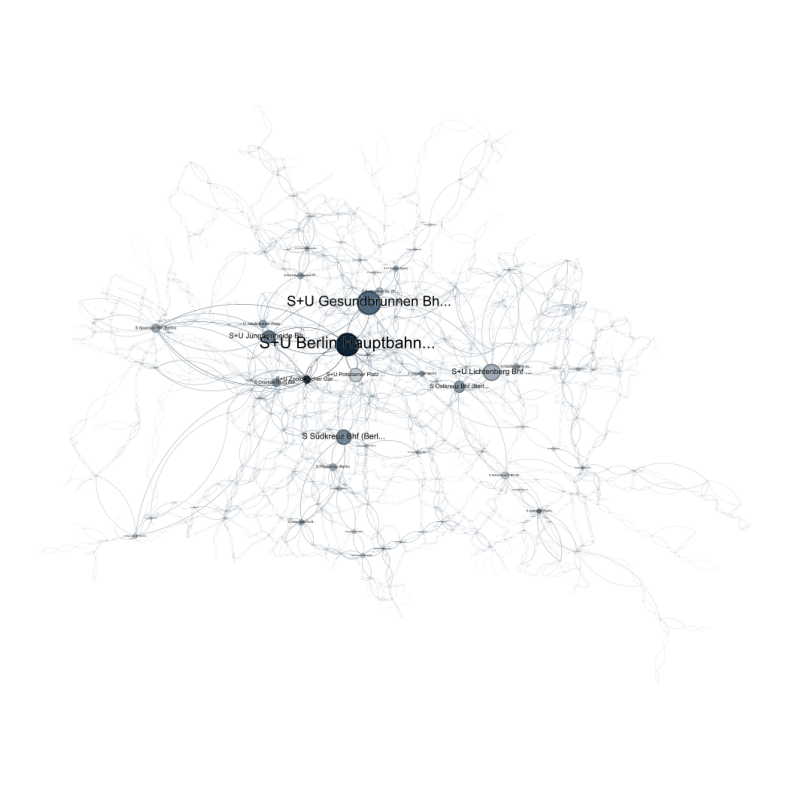

In [207]:
img = mpimg.imread('Gephi Graph1.png')
plt.figure(figsize=(10, 10)) 
plt.imshow(img)
plt.axis('off')
plt.show()

As can be seen, some stations are of considerable strategic importance within Berlin's public transport network. These stations act as central nodes for connections between different lines and areas of the city. The most important stations include Berlin Central Station (Hbf), GesundBrunnen Station, Berlin Südkreuz Station, Berlin Potsdamer Platz Station and Berlin Zoologischer Garten Station. These stations are crucial for the efficiency and fluidity of the public transport system, being connected to numerous lines and serving as key interchange points.

In [208]:
nx.write_gexf(G, "berlin_transport.gexf")

## 5. Network Analysis

This part of the project aims at analysing the network from the point of view of statistical metrics.

In [209]:
nx.read_gexf('berlin_transport.gexf')

### Degree Analysis

In [210]:
degrees = list(dict(G.degree()).values())
avg_degree = np.mean(degrees)
std_degree = np.std(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)

print(f'Minimum degree: {min_degree}')
print(f'Maximum degree: {max_degree}')
print(f'Average degree: {avg_degree}')
print(f'Standard deviation of degrees: {std_degree}')

Minimum degree: 1
Maximum degree: 30
Average degree: 5.014863463532665
Standard deviation of degrees: 2.638907015303745


In [244]:
in_degrees = list(dict(G.in_degree()).values())
out_degrees = list(dict(G.out_degree()).values())

avg_in_degree = np.mean(in_degrees)
avg_out_degree = np.mean(out_degrees)

print(f'Average in-degree: {avg_in_degree}')
print(f'Average out-degree: {avg_out_degree}')

Average in-degree: 2.5074317317663324
Average out-degree: 2.5074317317663324


Through degree calculations, it can be seen that on average each stop is connected to 5 other stops. This suggests that the network is relatively connected but not too dense. The standard deviation shows some route variability. In addition, the output suggests that some central stops have a maximum degree of 30 connections. This means that they could be the central stations or transportation hubs that are critical to the efficiency of the network.

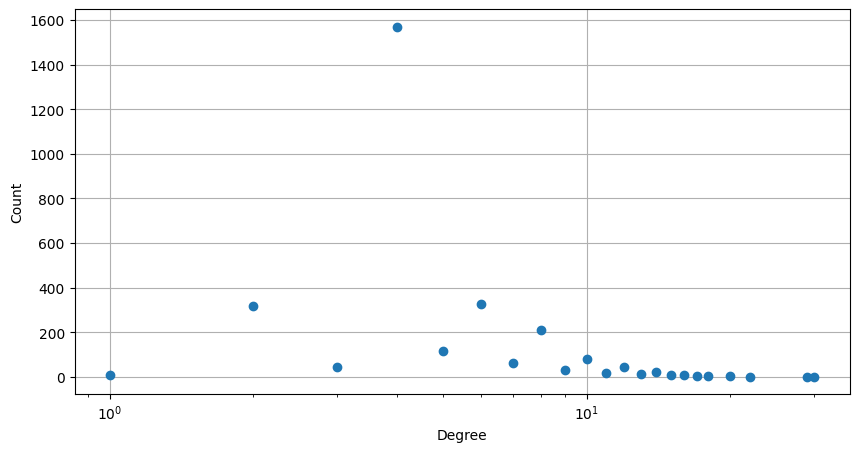

In [211]:
plt.figure(figsize=(10, 5))
plt.plot(*np.unique(degrees, return_counts=True), marker='o', linestyle='none')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.grid(True)
plt.show()

The degree distribution plot represents the number of nodes (stations or stops) for each degree of connection. It shows a peak concentration with a degree of 4, with about 1,600 nodes, while the stops with higher degrees, are much fewer in number. This indicates a hub and spoke type network, where most of the stops have relatively low connectivity, but there are central stations acting as hubs, with many more connections. The grade distribution is characterized by a rapid decline after grade 4, suggesting that many stops are connected to only a few other stops. This type of structure is typical of transportation networks covering large areas such as the city of Berlin with a few large centralized nodes.

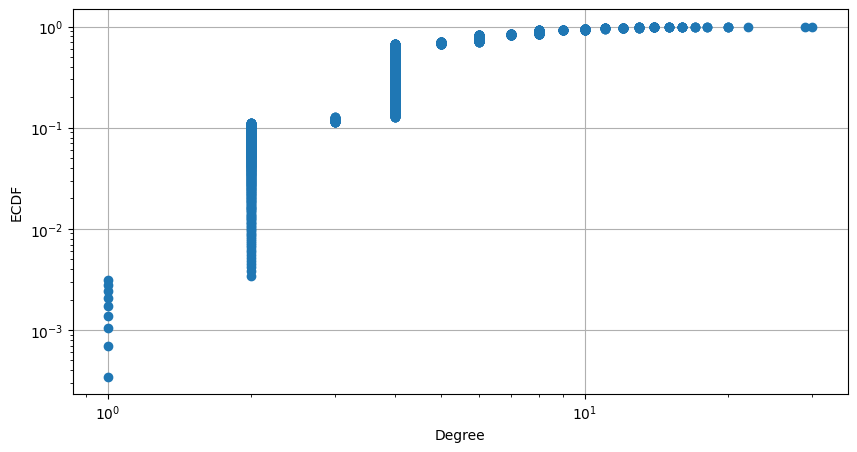

In [212]:
plt.figure(figsize=(10, 5))
ecdf = ECDF(degrees)
plt.plot(ecdf.x, ecdf.y, marker='o', linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('ECDF')
plt.grid(True)
plt.show()

The graph shows the ECDF (Empirical Cumulative Distribution Function) of the degree distribution in the public transport network on a log-log scale. The curve follows long-tailed features. The initial steepest part shows a large percentage of nodes with a low degree.

This type of network can be robust to random damage or failure, but extremely vulnerable to attack or damage to strategically important hubs.

As evidence of what has just been stated, it can be seen that 99% of stations are connected to a maximum of 14 other stations. So, only 1% of the nodes have a degree greater than 14, and thus hub cases are extremely rare. Logically, the disruption of these hubs and stations could have a huge impact on the whole efficiency of the system.

In [213]:
percentile_99 = np.percentile(degrees,99)
print(f'The 99th percentile of degrees is {round(percentile_99)}')

The 99th percentile of degrees is 14


### Comparison with a random graph (Erdős-Rényi model)

The Erdős-Rényi model is a random graph in which every pair of nodes has the same probability of being connected.  
To compare a real network with a random graph, a graph is generated with the same number of nodes and a probability \( p \) equal to the density of the real network.

**Formula:**

$$
p = D = \frac{2L}{N(N - 1)}
$$

Where:
- \( L \) is the number of archs
- \( N \) is the number of nodes

In [215]:
p = nx.density(G) 
p

0.000867023420389465

The value of the density shows that the real network of the public transport of Berlin is not really connected.

In [216]:
n_nodes, n_edges = G.order(), G.size()
random_graph = nx.fast_gnp_random_graph(n_nodes, p)
print('Number of nodes: {}'.format(random_graph.order()))
print('Number of links: {}'.format(random_graph.size()))

Number of nodes: 2893
Number of links: 3529


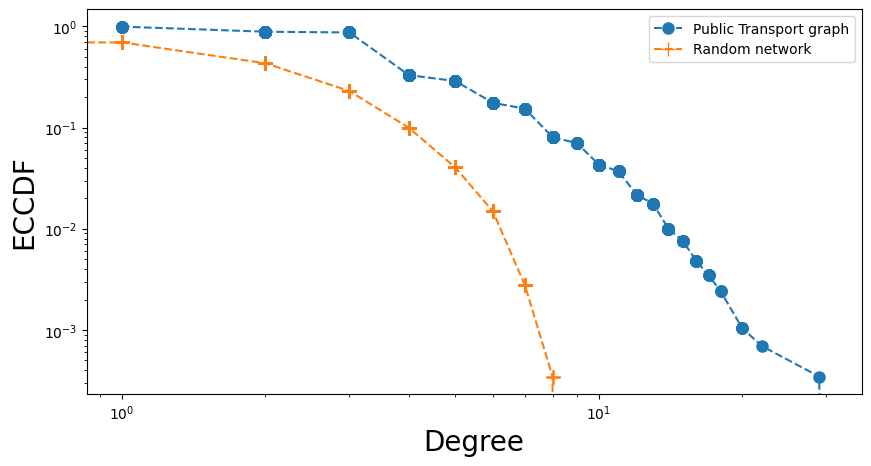

In [217]:
random_degrees = list(dict(random_graph.degree()).values())

ecdf_true = ECDF(degrees)
x_true = np.sort(degrees) 
y_true = 1 - ecdf_true(x_true)

ecdf_random = ECDF(random_degrees)
x_random = np.sort(random_degrees)
y_random = 1 - ecdf_random(x_random)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')

ax.loglog(x_true, y_true, marker='o', ms=8, linestyle='--', label='Public Transport graph')
ax.loglog(x_random, y_random, marker='+', ms=10, linestyle='--', label='Random network')

ax.set_xlabel('Degree', size=20)
ax.set_ylabel('ECCDF', size=20)
ax.legend(fontsize=10)
plt.show()

The graph shows the ECCDF of the degree distribution, comparing the real public transportation network with a random graph of Erdős-Rényi type. The curve of the real network is shifted to the right, indicating a greater presence of nodes with high degree compared to the random model. This suggests that the transportation network has a heterogeneous and planned structure, with a few highly connected hubs and many peripheral stations. In contrast, the random network has a more homogeneous distribution. Such behavior is typical of **Erdos-Renyi random graphs**, where the degree distribution follows a Poisson distribution (for large networks).

### Centrality Measures
Centrality measures are used to identify the most relevant or central nodes within a graph. In the context of this study, centralities are useful tools for identifying the most strategic and fundamental stops in the entire city network.

In [218]:
def top_n_ranks(centrality, n=10):
    return sorted(centrality, key=centrality.get, reverse=True)[:n]

The first indicator used is **degree centrality**, which measures the number of direct connections of a node. In other words, it indicates how many stops or stations are directly connected to a given node, either through edges arriving at or departing from that node. The more direct connections a node has, the greater its degree of centrality.

In the context of this public transport network, stops or stations with a high degree centrality are those that are connected to a large number of other stops. These stops are of strategic importance as they are nodal in the transport system, serving multiple transport lines.

In [219]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
print('Top 10 stations by degree centrality:')
top_degree_centrality = top_n_ranks(degree_centrality)
for i, streamer in enumerate(top_degree_centrality):
    print(f'{i + 1}: {streamer} - {degree_centrality[streamer]:.4f}')

Top 10 stations by degree centrality:
1: S+U Zoologischer Garten Bhf (Berlin) - 0.0104
2: S+U Berlin Hauptbahnhof - 0.0100
3: S+U Gesundbrunnen Bhf (Berlin) - 0.0076
4: S+U Jungfernheide Bhf (Berlin) - 0.0069
5: S+U Friedrichstr. Bhf (Berlin) - 0.0069
6: Landsberger Allee/Blumberger Damm (Berlin) - 0.0069
7: S Adlershof (Berlin) - 0.0069
8: S Charlottenburg Bhf (Berlin) - 0.0062
9: S Südkreuz Bhf (Berlin) - 0.0062
10: S Lichterfelde Ost Bhf (Berlin) - 0.0062


The ten stations with the highest degree of centrality in Berlin's public transport network are those with the most direct connections to other stops. The station with the highest rank is the Berlin Zoologischer Garten station located in a central neighborhood which is served by the S-bahn lines, the regional lines, the underground and the bus station. It was the most important traffic junction in the former West Berlin and is the best served station in terms of urban transport even compared to the central station. These stations represent high-traffic points with the largest passenger flows.

The next step is to calculate **closeness centrality**, which is a measure of how close a node is to all other nodes in the network. The node with high closeness centrality, on average, can reach other nodes in the network with the shortest path. It represents the central nodes in the network. They play a key role in traffic.

In [220]:
# Closeness centrality
close_centrality = nx.closeness_centrality(G) 
print('Top 10 stations by closeness centrality:')
top_close_centrality = top_n_ranks(close_centrality)
for i, streamer in enumerate(top_close_centrality):
    print(f'{i + 1}: {streamer} - {close_centrality[streamer]:.4f}')

Top 10 stations by closeness centrality:
1: S+U Berlin Hauptbahnhof - 0.1245
2: S+U Gesundbrunnen Bhf (Berlin) - 0.1226
3: S+U Jungfernheide Bhf (Berlin) - 0.1207
4: S+U Potsdamer Platz Bhf (Berlin) - 0.1169
5: S+U Lichtenberg Bhf (Berlin) - 0.1166
6: S+U Zoologischer Garten Bhf (Berlin) - 0.1152
7: S Bornholmer Str. (Berlin) - 0.1125
8: S Spandau Bhf (Berlin) - 0.1124
9: S+U Friedrichstr. Bhf (Berlin) - 0.1116
10: S+U Schönhauser Allee (Berlin) - 0.1116


These are the nodes that can easily reach the other stops, the most central nodes in the network. Berlin Central Station proves to be a main hub connecting numerous means of transport. Gesundbrunnen, Jungfernheide and Potsdamer Platz also appear to be the most central stations in the graph, making them extremely efficient for passenger transit.

The next step is the calculation of **betweenness centrality** which measures how much a node acts as an intermediary in connections between other nodes. A node that possesses this high measure lies on a large number of shortest paths between other pairs of nodes. It is strategically crucial for communication within the network. These nodes are important for the connectivity of the network, since without them, many connections between stations would be less efficient.

In [221]:
# Betweenness centrality
between_centrality = nx.betweenness_centrality(G, weight='weight') 
print('Top 10 stations by betweenness centrality:')
top_between_centrality = top_n_ranks(between_centrality)
for i, streamer in enumerate(top_between_centrality):
    print(f'{i + 1}: {streamer} - {between_centrality[streamer]:.4f}')

Top 10 stations by betweenness centrality:
1: S+U Gesundbrunnen Bhf (Berlin) - 0.4148
2: S+U Berlin Hauptbahnhof - 0.4104
3: S+U Lichtenberg Bhf (Berlin) - 0.3030
4: S Südkreuz Bhf (Berlin) - 0.2681
5: S+U Potsdamer Platz Bhf (Berlin) - 0.2450
6: S+U Jungfernheide Bhf (Berlin) - 0.2281
7: S Ostkreuz Bhf (Berlin) - 0.2046
8: S Spandau Bhf (Berlin) - 0.1496
9: S Bornholmer Str. (Berlin) - 0.1479
10: S Charlottenburg Bhf (Berlin) - 0.1416


These stations are crucial interchange points through which shorter routes between other stops pass, making the system more integrated and efficient. Gesundbrunnen station, located in the north of Berlin, connects the S-bahn, regional transport, underground and buses, facilitating connections between different areas of the city.


The next step is the calculation of **eigenvector centrality**. This measure takes into account not only the number of connections of a node, but also the quality of the connections. A node has high centrality if it is connected to nodes that are themselves well connected. A node with high centrality is also important because it is connected to highly influential nodes. These stops are important because they are connected to strategic nodes. 

In [222]:
# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight') 
print('Top 10 stations by eigenvector centrality:')
top_eigenvector_centrality = top_n_ranks(eigenvector_centrality)
for i, streamer in enumerate(top_eigenvector_centrality):
    print(f'{i + 1}: {streamer} - {eigenvector_centrality[streamer]:.4f}')

Top 10 stations by eigenvector centrality:
1: S+U Zoologischer Garten Bhf (Berlin) - 0.3794
2: S+U Berlin Hauptbahnhof - 0.3687
3: S+U Jungfernheide Bhf (Berlin) - 0.2452
4: S Charlottenburg Bhf (Berlin) - 0.2349
5: S+U Gesundbrunnen Bhf (Berlin) - 0.2322
6: S Spandau Bhf (Berlin) - 0.1899
7: S+U Friedrichstr. Bhf (Berlin) - 0.1596
8: S Messe Nord/ICC (Berlin) - 0.1477
9: U Kurfürstendamm (Berlin) - 0.1312
10: U Wittenbergplatz (Berlin) - 0.1310


Obeserving this result, the stations S Messe Nord/ICC and S Spandau Bhf, although not having the maximum number of direct connections, are strategically important for Berlin's public transport network. Their high centrality indicates that they are connected to central and influential bus stops, making them key interchange points for the efficiency and connectivity of the system.

## 6. Community Detection

Community detection is a central technique in the analysis of complex networks. Its purpose is to identify groups/clusters of nodes that show a high density of internal connections, as opposed to a smaller number of connections to the rest of the network.

In the application domain, a community may represent, for example, a set of strongly interconnected public transportation stations, suggesting functional or geographic cohesion within the network.

### Louvain method

One of the most effective and popular algorithms for community identification is Louvain's method. It is a greedy optimization algorithm that aims to maximize modularity, a measure that compares the density of links within communities with that expected in a random graph. Modularity takes on larger values when nodes within the same community are more connected to each other than would be expected by chance.

Main steps:

- Each node is initially assigned to a distinct community.
- For each node, the gain in modularity from moving into each of its neighbors' communities is evaluated.
- The node is moved to the community that produces the maximum (positive) gain in modularity.
- This procedure is repeated iteratively for all nodes until modularity can no longer be improved.

In [224]:
louvain = community.louvain_communities(G, weight='weight', seed=42)
n_communities_louvain = len(louvain)
print(f'Number of communities: {n_communities_louvain}')

Number of communities: 33


The Louvain method detected 33 communities in the network, each representing a group of strongly interconnected nodes (stops or stations).

In [225]:
louvain = sorted(louvain, key=len, reverse=True)
for i, com in enumerate(louvain):
    print(f'Community {i + 1}: {len(com)} stations or stops')

Community 1: 168 stations or stops
Community 2: 157 stations or stops
Community 3: 156 stations or stops
Community 4: 149 stations or stops
Community 5: 132 stations or stops
Community 6: 129 stations or stops
Community 7: 121 stations or stops
Community 8: 121 stations or stops
Community 9: 113 stations or stops
Community 10: 108 stations or stops
Community 11: 106 stations or stops
Community 12: 103 stations or stops
Community 13: 102 stations or stops
Community 14: 97 stations or stops
Community 15: 96 stations or stops
Community 16: 93 stations or stops
Community 17: 91 stations or stops
Community 18: 87 stations or stops
Community 19: 73 stations or stops
Community 20: 72 stations or stops
Community 21: 72 stations or stops
Community 22: 67 stations or stops
Community 23: 58 stations or stops
Community 24: 55 stations or stops
Community 25: 52 stations or stops
Community 26: 51 stations or stops
Community 27: 49 stations or stops
Community 28: 47 stations or stops
Community 29: 46

In [226]:
louvain_sizes = [len(com) for com in louvain]
avg_lou_size = np.mean(louvain_sizes)
max_lou_size = np.max(louvain_sizes)
min_lou_size = np.min(louvain_sizes)
print(f'Average community size: {avg_lou_size}')
print(f'Maximum community size: {max_lou_size}')
print(f'Minimum community size: {min_lou_size}')

Average community size: 87.66666666666667
Maximum community size: 168
Minimum community size: 16


These values suggest some heterogeneity in the structure of the network: some communities are very large, while others are more compact, probably connected to outlying or underserved areas.

In [227]:
def assign_community(G, community, name):
    for i, l_com in enumerate(community):
        for n in l_com: 
            G.nodes[n][name] = i

In [228]:
assign_community(G, louvain, 'com_louv')

In [229]:
nx.write_gexf(G, 'stations_community_detection.gexf')

In [230]:
size = [len(com_set) for com_set in louvain]

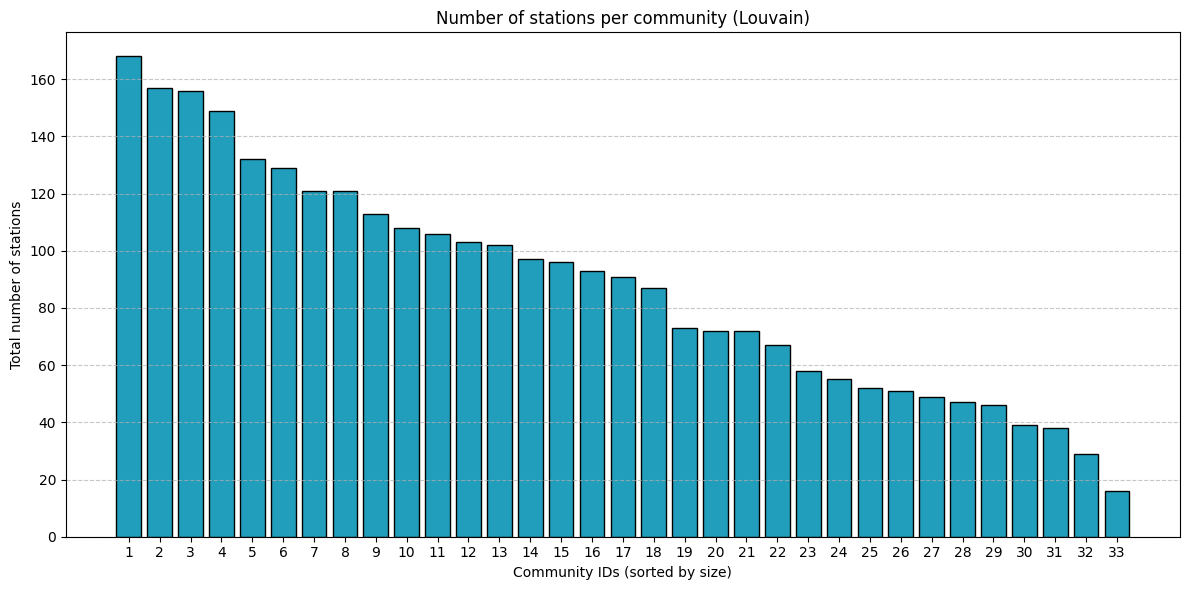

In [231]:
sorted_sizes = sorted(enumerate(size), key=lambda x: x[1], reverse=True)
community_indices = [i+1 for i, _ in sorted_sizes]  
sizes_sorted = [size for _, size in sorted_sizes]

plt.figure(figsize=(12, 6))
plt.bar(community_indices, sizes_sorted, color='#219ebc', edgecolor='black')
plt.title('Number of stations per community (Louvain)')
plt.xlabel('Community IDs (sorted by size)')
plt.ylabel('Total number of stations')
plt.xticks(community_indices)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

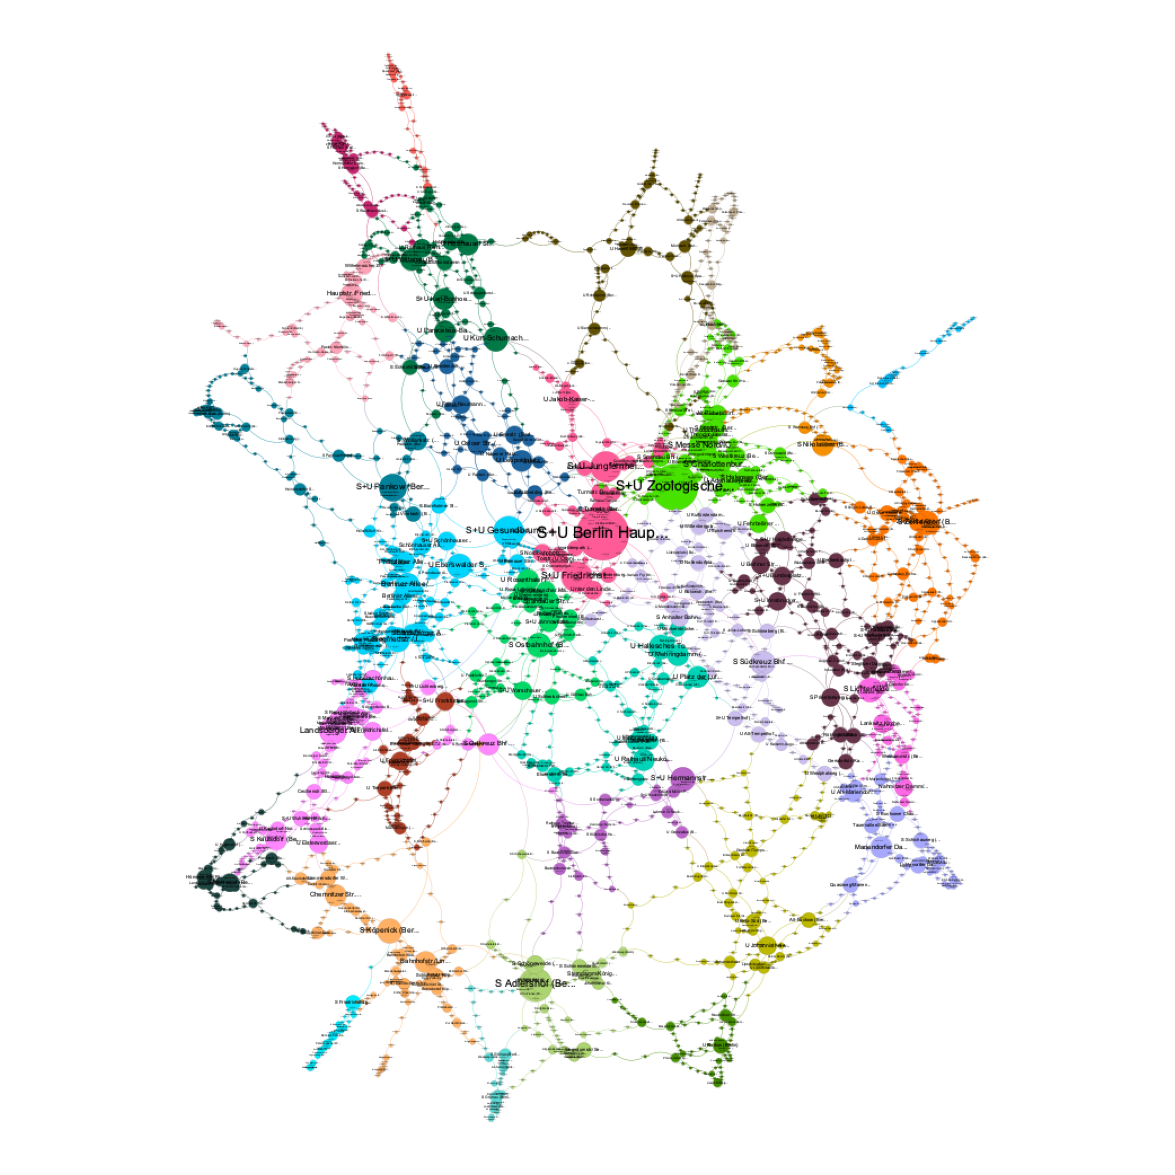

In [232]:
img = mpimg.imread('Community Berlin Public Transport.png')
plt.figure(figsize=(15, 15)) 
plt.imshow(img)
plt.axis('off')
plt.show()

The larger community identified by Louvain (in light blue) covers the central-west area of Berlin, a highly interconnected area well served by public transport. Within it lies Gesundbrunnen, a major rail and metro hub located in the Mitte district. This community reflects the high urban density of the heart of the city with numerous U-Bahn, S-Bahn and regional lines.

The second community (in orange) by number of stations is located further northeast, in a more residential and green area of the city. It includes stations such as Nikolassee and Zehlendorf, both located in the Steglitz-Zehlendorf district. This area, while more peripheral than the historic center, is well connected.

In third position (in light green) we find a community where the Zoologischer Garten, a highly touristy area, is located.

Smaller communities are distributed along the edges of the city, in suburban neighborhoods. These areas have a lower density of connections and are home to less centrally located stations, often connected by a few lines and served mainly by S-Bahn lines or suburban buses.

## 7. Link Prediction

In the context of Berlin's public transportation network, an interesting application of machine learning on graphs is link prediction, that is, the prediction of the possible future existence of a direct link between two currently unconnected stops. This type of analysis is particularly useful for planning new routes or network extensions and identifying missing links that would improve connectivity.

To address this problem, Node2Vec was used to generate vector embeddings of the nodes and then trained a supervised classifier to estimate the probability of existence of a link between two nodes.


To complete this task, I decided to filter the dataset considering only rail stops (thus excluding other stops such as bus stops). This is to prevent the model from generating insignificant connections due to the geographic proximity between bus stops, but not relevant from the structural point of view of the network.
As before, each train stop is represented as a node, while the arcs correspond to direct connections between stops.

In [233]:
network_train_df = network_df[network_df.route_type == 2]
network_train_df

from                 from_name  from_long   from_lat  \
169     111    S+U Westhafen (Berlin)  13.343842  52.536186   
175     111    S+U Westhafen (Berlin)  13.343842  52.536186   
381     133       S Bellevue (Berlin)  13.347104  52.519954   
396     133       S Bellevue (Berlin)  13.347104  52.519954   
404     134     S Tiergarten (Berlin)  13.336240  52.513966   
...     ...                       ...        ...        ...   
28548  2946      S Adlershof (Berlin)  13.540559  52.435106   
28555  2946      S Adlershof (Berlin)  13.540559  52.435106   
29167  3020   S Altglienicke (Berlin)  13.559608  52.407794   
29180  3020   S Altglienicke (Berlin)  13.559608  52.407794   
29271  3037  S Grünbergallee (Berlin)  13.543228  52.399543   

                     from_geometry    to  \
169    POINT (13.343842 52.536186)   220   
175    POINT (13.343842 52.536186)   357   
381    POINT (13.347104 52.519954)   146   
396    POINT (13.347104 52.519954)   134   
404     POINT (13.33624 52.513966)   389   
...                            ...   ...   
28548  POINT (13.540559 52.435106)  3020   
28555  POINT (13.540559 52.435106)  2881   
29167  POINT (13.559608 52.407794)  2946   
29180  POINT (13.559608 52.407794)  3037   
29271  POINT (13.543228 52.399543)  3020   

                                    to_name    to_long     to_lat  \
169                    S+U Wedding (Berlin)  13.366065  52.542735   
175                  S Beusselstr. (Berlin)  13.328708  52.534317   
381                 S+U Berlin Hauptbahnhof  13.368930  52.525851   
396                   S Tiergarten (Berlin)  13.336240  52.513966   
404    S+U Zoologischer Garten Bhf (Berlin)  13.332713  52.506924   
...                                     ...        ...        ...   
28548               S Altglienicke (Berlin)  13.559608  52.407794   
28555                     S Grünau (Berlin)  13.574024  52.412717   
29167                  S Adlershof (Berlin)  13.540559  52.435106   
29180              S Grünbergallee (Berlin)  13.543228  52.399543   
29271               S Altglienicke (Berlin)  13.559608  52.407794   

                       to_geometry  route_type  n_vehicles  duration_avg     d  
169    POINT (13.366065 52.542735)           2         368    120.000000  1671  
175    POINT (13.328708 52.534317)           2         354     60.000000  1045  
381     POINT (13.36893 52.525851)           2         352    159.375000  1617  
396     POINT (13.33624 52.513966)           2         352     80.454545   992  
404    POINT (13.332713 52.506924)           2         352     80.454545   819  
...                            ...         ...         ...           ...   ...  
28548  POINT (13.559608 52.407794)           2         121    240.000000  3303  
28555  POINT (13.574024 52.412717)           2         162    192.592593  3372  
29167  POINT (13.540559 52.435106)           2         120    240.000000  3303  
29180  POINT (13.543228 52.399543)           2         121    120.000000  1442  
29271  POINT (13.559608 52.407794)           2         120    120.000000  1442  

[326 rows x 14 columns]

In [234]:
G_train = nx.DiGraph()

for _, row in network_train_df.iterrows():
    G_train.add_node(row['from_name'], lat=row['from_lat'], lon=row['from_long'])
    G_train.add_node(row['to_name'], lat=row['to_lat'], lon=row['to_long'])
    

for _, row in network_train_df.iterrows():
    G_train.add_edge(
        row['from_name'], row['to_name'],
        n_vehicles=row['n_vehicles'],
        duration_avg=row['duration_avg'],
        d=row['d'],
        route_type=row['route_type'] 
    )
G_train.remove_edges_from(nx.selfloop_edges(G_train))

In [235]:
node2vec = Node2Vec(
    G_train,
    dimensions=64,
    walk_length=30,
    num_walks=200,
    p=1,
    q=0.5,
    workers=2,
    weight_key='n_vehicles'
)
model = node2vec.fit(window=10, min_count=1)

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:00<00:00, 105.89it/s]


The random walks of Node2Vec were driven using the number of vehicles (n_vehicles) passing over each link as the weight. This approach favors the generation of embeddings that take into account the frequency of travel, thus reflecting a higher structural and operational probability between stops. The results obtained show that traffic information has a significant impact on the quality of link prediction.

In [236]:
def get_edge_embedding(u, v):
    try:
        return model.wv[u] + model.wv[v]
    except KeyError:
        return None

In [237]:
positive_edges = [(u, v, 1) for u, v in G_train.edges()]
G_nodes = list(G_train.nodes())

def generate_hard_negatives(G_train, num_samples):
    negatives = set()
    while len(negatives) < num_samples:
        u = random.choice(G_nodes)
        neighbors = list(nx.single_source_shortest_path_length(G_train, u, cutoff=2).keys())
        potential = [v for v in neighbors if v != u and not G_train.has_edge(u, v)]
        if potential:
            v = random.choice(potential)
            negatives.add((u, v))
    return [(u, v, 0) for u, v in negatives]

negative_edges = generate_hard_negatives(G_train, len(positive_edges))

In [238]:
all_samples = positive_edges + negative_edges
random.shuffle(all_samples)

X, y = [], []
for u, v, label in all_samples:
    vec = get_edge_embedding(u, v)
    if vec is not None:
        X.append(vec)
        y.append(label)

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [240]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

Accuracy: 0.736
ROC AUC: 0.800


The results show that the model works quite well.
With an accuracy of 73.6%, it can correctly predict almost 7 out of 10 links.
The ROC AUC value of 0.80 indicates that the model can effectively distinguish between real and nonexistent connections.
Overall, these results suggest that the approach is useful in identifying possible new connections in the transportation network.

In [241]:
candidates = set()
for u in G_train.nodes():
    neighbors = nx.single_source_shortest_path_length(G_train, u, cutoff=2).keys()
    for v in neighbors:
        if u != v and not G_train.has_edge(u, v):
            candidates.add(tuple(sorted((u, v))))

candidates = list(candidates)
random.shuffle(candidates)
candidates = candidates[:5000]

X_new = []
pairs = []
for u, v in candidates:
    vec = get_edge_embedding(u, v)
    if vec is not None:
        X_new.append(vec)
        pairs.append((u, v))

y_proba = clf.predict_proba(X_new)[:, 1]
results = list(zip(pairs, y_proba))

results.sort(key=lambda x: x[1], reverse=True)
print("\n Top new suggested arcs::")
for (u, v), p in results[:30]:
    print(f"{u} <-> {v} | Probability: {p:.3f}")


 Top new suggested arcs::
S Messe Nord/ICC (Berlin) <-> S+U Jungfernheide Bhf (Berlin) | Probability: 0.724
S Schöneberg (Berlin) <-> S+U Bundesplatz (Berlin) | Probability: 0.721
S Hohenzollerndamm (Berlin) <-> S Westkreuz (Berlin) | Probability: 0.719
S Lichterfelde West (Berlin) <-> S+U Rathaus Steglitz (Berlin) | Probability: 0.715
S Halensee (Berlin) <-> S Messe Nord/ICC (Berlin) | Probability: 0.685
S Messe Süd (Berlin) <-> S Olympiastadion (Berlin) | Probability: 0.679
S+U Jungfernheide Bhf (Berlin) <-> S+U Wedding (Berlin) | Probability: 0.660
S Beusselstr. (Berlin) <-> S Westend (Berlin) | Probability: 0.651
S+U Alexanderplatz Bhf (Berlin) <-> S+U Warschauer Str. (Berlin) | Probability: 0.650
S Charlottenburg Bhf (Berlin) <-> S+U Jungfernheide Bhf (Berlin) | Probability: 0.633
S Südkreuz Bhf (Berlin) <-> S+U Innsbrucker Platz (Berlin) | Probability: 0.624
S Schönholz (Berlin) <-> S+U Karl-Bonhoeffer-Nervenklinik (Berlin) | Probability: 0.618
S Friedenau (Berlin) <-> S+U Innsb

In this step, we generated a list of candidate stop pairs that are not currently connected in the network, but are within a distance of two hops (cutoff=2).
The idea is to focus on potentially useful and realistic connections, avoiding pairings that are too far apart geographically or topologically.

For each candidate pair, an arc embedding was calculated and passed to the model to obtain a probability of link existence. The pairs were then sorted according to this probability.

The output shows the 30 most likely connections according to the model, with high probability values (up to 0.88), suggesting plausible connections between stops that are often close or logically related. These results could provide useful insights for evaluating future network extensions or connectivity improvements.

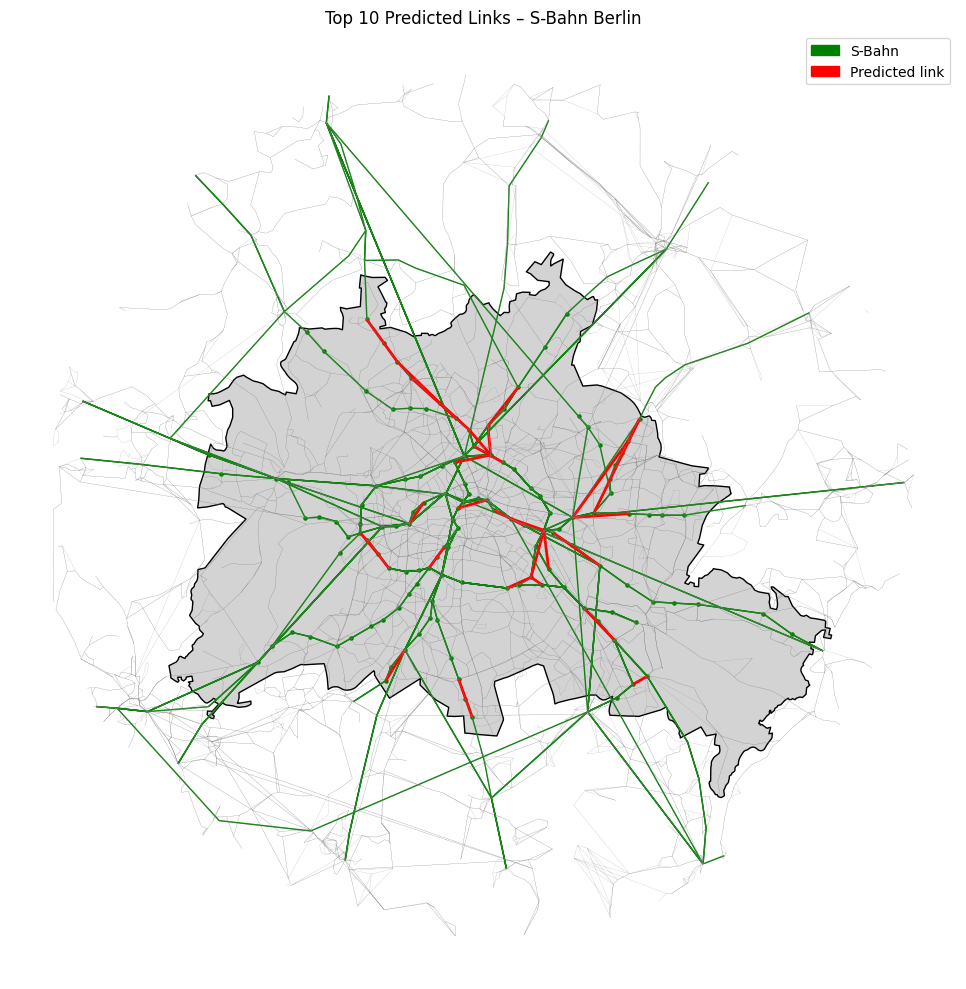

In [242]:
from_stops = network_train_df[['from_name', 'from_lat', 'from_long']].rename(
    columns={'from_name': 'name', 'from_lat': 'lat', 'from_long': 'lon'}
)
to_stops = network_train_df[['to_name', 'to_lat', 'to_long']].rename(
    columns={'to_name': 'name', 'to_lat': 'lat', 'to_long': 'lon'}
)
all_stops = pd.concat([from_stops, to_stops]).drop_duplicates('name')

gdf = gpd.GeoDataFrame(all_stops, geometry=gpd.points_from_xy(all_stops['lon'], all_stops['lat']))
gdf.set_crs(epsg=4326, inplace=True)

top_predictions = [
    ("S Waidmannslust (Berlin)", "S Wilhelmsruh (Berlin)", 0.885),
    ("S Buckower Chaussee (Berlin)", "S Lichtenrade (Berlin)", 0.805),
    ("S Frohnau (Berlin)", "S Waidmannslust (Berlin)", 0.796),
    ("S Mehrower Allee (Berlin)", "S+U Lichtenberg Bhf (Berlin)", 0.736),
    ("S Blankenburg (Berlin)", "S+U Pankow (Berlin)", 0.733),
    ("S Ahrensfelde Bhf (Berlin)", "S Raoul-Wallenberg-Str. (Berlin)", 0.706),
    ("S Lichterfelde Ost Bhf (Berlin)", "S Lichterfelde Süd (Berlin)", 0.673),
    ("S Ostbahnhof (Berlin)", "S Ostkreuz Bhf (Berlin)", 0.667),
    ("S Adlershof (Berlin)", "S Schöneweide Bhf (Berlin)", 0.664),
    ("S Sonnenallee (Berlin)", "S+U Hermannstr. (Berlin)", 0.659),
    ("S Bellevue (Berlin)", "S+U Zoologischer Garten Bhf (Berlin)", 0.655),
    ("S Halensee (Berlin)", "S+U Heidelberger Platz (Berlin)", 0.647),
    ("S Ostkreuz Bhf (Berlin)", "S Sonnenallee (Berlin)", 0.647),
    ("S Karlshorst Bhf (Berlin)", "S Rummelsburg (Berlin)", 0.644),
    ("S Hohenzollerndamm (Berlin)", "S Westkreuz (Berlin)", 0.643),
    ("S Altglienicke (Berlin)", "S Grünau (Berlin)", 0.633),
    ("S Köllnische Heide (Berlin)", "S Sonnenallee (Berlin)", 0.626),
    ("S Ostkreuz Bhf (Berlin)", "S Plänterwald (Berlin)", 0.624),
    ("S Schönholz (Berlin)", "S+U Wittenau (Berlin)", 0.624),
    ("S Ahrensfelde Bhf (Berlin)", "S Friedrichsfelde Ost (Berlin)", 0.611),
    ("S Wilhelmsruh (Berlin)", "S Wollankstr. (Berlin)", 0.592),
    ("S Biesdorf (Berlin)", "S+U Lichtenberg Bhf (Berlin)", 0.591),
    ("S Humboldthain (Berlin)", "S+U Schönhauser Allee (Berlin)", 0.588),
    ("S+U Alexanderplatz Bhf (Berlin)", "S+U Brandenburger Tor (Berlin)", 0.577),
    ("S+U Yorckstr. S1 U7 (Berlin)", "S+U Yorckstr. S2 S25 U7 (Berlin)", 0.573),
    ("S Schöneberg (Berlin)", "S+U Yorckstr. S1 U7 (Berlin)", 0.573),
    ("S Bornholmer Str. (Berlin)", "S Prenzlauer Allee (Berlin)", 0.569),
    ("S+U Jannowitzbrücke (Berlin)", "S+U Warschauer Str. (Berlin)", 0.566),
    ("S Wollankstr. (Berlin)", "S+U Schönhauser Allee (Berlin)", 0.562),
    ("S+U Pankow (Berlin)", "S+U Schönhauser Allee (Berlin)", 0.562)
]

MIN_DIST_METERS = 500
filtered_predictions = []
for u, v, prob in top_predictions:
    try:
        coord_u = gdf[gdf['name'] == u][['lat', 'lon']].iloc[0]
        coord_v = gdf[gdf['name'] == v][['lat', 'lon']].iloc[0]
        dist = geodesic((coord_u['lat'], coord_u['lon']), (coord_v['lat'], coord_v['lon'])).meters
        if dist >= MIN_DIST_METERS:
            filtered_predictions.append((u, v, prob))
    except:
        print(f"⚠️ Fermata mancante: {u} o {v}")
        continue

lines = []
for u, v, prob in filtered_predictions:
    try:
        point_u = gdf[gdf['name'] == u].iloc[0].geometry
        point_v = gdf[gdf['name'] == v].iloc[0].geometry
        lines.append({
            'u': u,
            'v': v,
            'prob': prob,
            'geometry': LineString([point_u, point_v])
        })
    except:
        continue

predicted_links_gdf = gpd.GeoDataFrame(lines)
predicted_links_gdf.set_geometry('geometry', inplace=True)
predicted_links_gdf.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(figsize=(10, 10))

city_map = gpd.read_file('berlin/berlin_map.geojson')
city_map.plot(ax=ax, color='lightgrey', edgecolor='black')

gdf.plot(ax=ax, marker='o', color='green', markersize=5, label='S-Bahn Stations')

routes = gpd.read_file('berlin/routes.geojson')
routes[routes['route_type'] == 2].plot(ax=ax, color='green', linewidth=1, label='S-Bahn Routes')

predicted_links_gdf.plot(ax=ax, color='red', linewidth=2, label='Predicted links')

sections = gpd.read_file('berlin/sections.geojson')
sections.plot(ax=ax, color='grey', linewidth=0.1)

legend_labels = [
    mpatches.Patch(color='green', label='S-Bahn'),
    mpatches.Patch(color='red', label='Predicted link')
]
ax.legend(handles=legend_labels)

plt.title('Top 10 Predicted Links – S-Bahn Berlin')
plt.axis('off')
plt.tight_layout()
plt.show()